In [3]:
%load_ext autoreload 
%autoreload 2

In [6]:
from plaid.diffusion.dpm_samplers import *
import numpy as np
import torch
import seaborn as sns
import matplotlib.pyplot as plt

import typing as T

device = torch.device("cuda")

In [7]:
sigma_min = 1e-2
sigma_max = 160
n = 100

sigmas = get_sigmas_karras(n, sigma_min, sigma_max, rho=7., device=device)
discrete_schedule = DiscreteSchedule(sigmas, quantize=True)

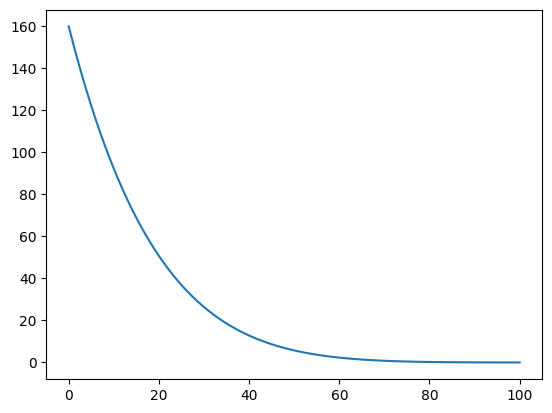

In [8]:
plt.plot(sigmas.cpu())

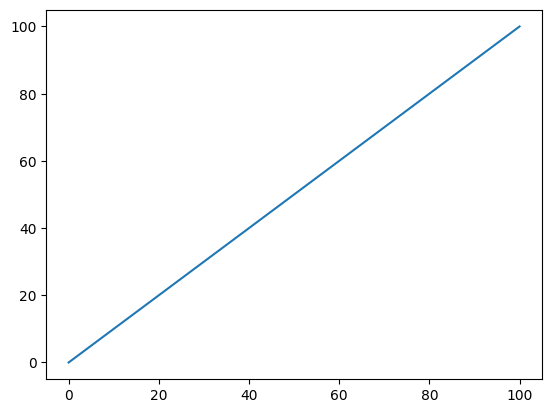

In [9]:
T = discrete_schedule.sigma_to_t(sigmas)
plt.plot(T.cpu())

In [40]:
min_len = 40
max_len = 60

lens = torch.arange(min_len, max_len)
print(len(lens))

mask = torch.zeros(len(lens), max_len).bool()

for i, l in enumerate(lens):
    mask[i, :l] = torch.ones((l,)).bool()

mask = torch.cat([mask,mask])
mask.shape

20


torch.Size([40, 60])

In [6]:
from plaid.datasets import NUM_FUNCTION_CLASSES, NUM_ORGANISM_CLASSES

extra_args = {
    "function_idx": NUM_FUNCTION_CLASSES,
    "organism_idx": NUM_ORGANISM_CLASSES,
    "mask": None,
    "cond_scale": 1.,
    "rescaled_phi": 0.7,
}

In [7]:
import hydra
from omegaconf import OmegaConf
cfg = OmegaConf.load("/homefs/home/lux70/code/plaid/configs/pipeline/sample_latent.yaml")
if "defaults" in cfg.keys():
    cfg.pop("defaults")

from plaid.pipeline import SampleLatent

diffusion = SampleLatent(**cfg).diffusion
diffusion = diffusion.to(device)

/homefs/home/lux70/code/plaid/src/plaid/pipeline/_sample.py:119: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(model_path)


In [8]:
class ModelWrapper(torch.nn.Module):
    def __init__(self, model, discrete_schedule):
        super().__init__()
        self.model = model
        self.discrete_schedule = discrete_schedule

    def forward(
        self,
        x,
        sigmas, 
        x_self_cond=None,
        function_idx=None,
        organism_idx=None,
        mask=None,
        cond_scale: float = 6.0,
        rescaled_phi: float = 0.7,
    ):
        T = self.discrete_schedule.sigma_to_t(sigmas)
        denoiser_kwargs = self.model.sample_step_inputs_to_kwargs(x, T, x_self_cond, function_idx, organism_idx, mask)
        pred = self.model.model_predictions(denoiser_kwargs, cond_scale, rescaled_phi)
        x, eps = pred.pred_x_start, pred.pred_noise
        return x

model = ModelWrapper(diffusion, discrete_schedule)

In [9]:
N, L, C = 512, 128, 32
x = torch.randn((N, L, C)).to(device)

sigma_min = 1e-2
sigma_max = 160
n = 30
sigmas = get_sigmas_karras(n, sigma_min, sigma_max, rho=7., device=device)

x = sample_dpmpp_2m_sde(model, x, sigmas, extra_args=extra_args, return_intermediates=True)

  0%|          | 0/30 [00:00<?, ?it/s]

/homefs/home/lux70/micromamba/envs/plaid-train/lib/python3.10/site-packages/torchsde/_brownian/brownian_interval.py:599: UserWarning: Should have ta>=t0 but got ta=0.009999996051192284 and t0=0.01.
  warnings.warn(f"Should have ta>=t0 but got ta={ta} and t0={self._start}.")


In [10]:
from plaid.evaluation import ConditionalFID

fid_eval = ConditionalFID()

In [19]:
x.shape
x = torch.tensor(x).to(device)

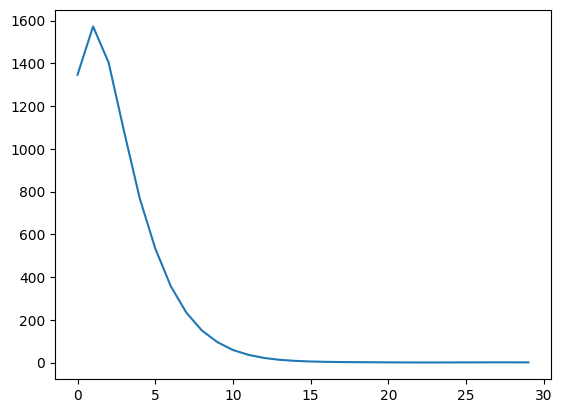

In [20]:
fids = []

for i in range(n):
    feat = x[:, i, :, :].cpu().numpy()
    feat = feat.mean(axis=1)
    fid = fid_eval.run(feat)
    fids.append(fid)

import matplotlib.pyplot as plt
plt.plot(fids)

In [21]:
fids[-1]

0.9161299355554983

In [24]:
from cheap.proteins import LatentToSequence, LatentToStructure
from cheap.pretrained import CHEAP_pfam_shorten_2_dim_32

cheap = CHEAP_pfam_shorten_2_dim_32()
cheap = cheap.to(device)

Using tanh layer at bottleneck...
Finished loading HPCT model with shorten factor 2 and 32 channel dimensions.
Creating ESMFold embedding only model...
ESMFold embedding only model created in 29.01 seconds


In [26]:
latent_to_sequence = LatentToSequence()
latent_to_structure = LatentToStructure()

/homefs/home/lux70/code/cheap-proteins/src/cheap/decoder.py:92: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(ckpt_path)
Creating ESMFold...
ESMFold model 

In [1]:
from cheap.utils import LatentScaler

latent_scaler = LatentScaler()
latent = cheap.hourglass_model.decode(x[:, -1, :, :])
latent = latent_scaler.unscale(latent)

NameError: name 'cheap' is not defined

In [36]:
sequences = latent_to_sequence.to_sequence(latent)[-1]

In [ ]:
structures = latent_to_structure.to_structure(latent, sequences)

In [ ]:
sequences

In [ ]:
import py3Dmol

# for i in range(len(pdb_strs)):
# for i in range(10,20): 
# for i in range(0, 10): 
for i in range(20,30): 
    view = py3Dmol.view(width=600, height=600)
    view.addModelsAsFrames(pdb_strs[i])
    
    # Apply the plDDT color scheme
    # view.setStyle({'cartoon': {'color': {'prop': 'b', 'gradient': 'roygb', 'min': 0, 'max': 100}}})
    view.setStyle({'cartoon': {'color': {'prop': 'b', 'gradient': 'roygb', 'min': 50, 'max': 90}}})
    
    # # Add surface representation with plDDT-based color
    view.addSurface(py3Dmol.VDW, {'opacity': 0.7, 'colorscheme': {'prop': 'b', 'gradient': 'roygb', 'min': 50, 'max': 90}})
    # view.addSurface(py3Dmol.VDW, {'opacity': 0.7, 'colorscheme': {'prop': 'b', 'gradient': 'roygb', 'min': 0, 'max': 100}})

    view.zoomTo()
    view.show()